### Read in data

In [2]:
import pandas as pd

# manually create col_names.csv as learn/test files came with no column names
col_names = pd.read_csv('../data/col_names.csv', header=None)
learn = pd.read_csv('../data/census_income_learn.csv', names=col_names[0].values.tolist())
test = pd.read_csv('../data/census_income_test.csv', names=col_names[0].values.tolist())

In [3]:
print(f"Learning data shape: {learn.shape}")
print(f"Test data shape: {test.shape}")

Learning data shape: (199523, 42)
Test data shape: (99762, 42)


#### Data manipulation
- Clean up column names to make more readable
- Drop columns that don't make sense: I had to self-map the column names so could've been an error: e.g. wage per hour mean is $55 - this isn't true of the population
- Codes (industry and occupation) not needed as there are string equivalents
- Binarize target

In [4]:
columns_to_drop = ['veterans_benefits', 'own_business_or_self_employed', 'instance_weight', 'occupation_code', 'industry_code', 'wage_per_hour']
learn.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
learn.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
test.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# define target
learn['target'] = learn['target'].replace(' - 50000.', 0)
learn['target'] = learn['target'].replace(' 50000+.', 1)
test['target'] = test['target'].replace(' - 50000.', 0)
test['target'] = test['target'].replace(' 50000+.', 1)

In [5]:
# check spread of binary target
learn['target'].value_counts()

target
0    187141
1     12382
Name: count, dtype: int64

In [6]:
pd.options.display.max_columns = None

# inspect learning df
learn.sample(3)

,age,class_of_worker,education,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,race,hispanic_Origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,divdends_from_stocks,tax_filler_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_inc_questionnaire_for_veteran's_admin,weeks_worked_in_year,year,target
166778,65,Not in universe,Some college but no degree,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint one under 65 & one 65+,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not in universe,0,95,0
11341,68,Not in universe,7th and 8th grade,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Householder,Householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Yes,0,94,0
166093,9,Not in universe,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,Not in universe,0,94,0


# EDA

- 'Not in universe' or '?' means missing or not applicable for string columns
- Some very skewed numerical features (`capital_gains`, `capital_losses`, `divdends_from_stocks`) - should transform
- 6% earn over 50k
- Some groups can't earn over $50k a year - e.g. Children or weeks worked==0
- High cardinality in some varibales: grouped where necessary for better visuals
- Learn & Test have similar distributions for most columns

#### Any duplicates?

In [8]:
print("Original size:", learn.shape[0])

duped = learn.duplicated()
print("Duplicated rows:", duped.sum())

Original size: 199523
Duplicated rows: 47187


In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)

# numerical column descriptives
learn.describe()

,age,capital_gains,capital_losses,divdends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year,year,target
count,199523.00,199523.00,199523.00,199523.00,199523.00,199523.00,199523.00,199523.00
mean,34.49,434.72,37.31,197.53,1.96,23.17,94.50,0.06
std,22.31,4697.53,271.90,1984.16,2.37,24.41,0.50,0.24
min,0.00,0.00,0.00,0.00,0.00,0.00,94.00,0.00
25%,15.00,0.00,0.00,0.00,0.00,0.00,94.00,0.00
50%,33.00,0.00,0.00,0.00,1.00,8.00,94.00,0.00
75%,50.00,0.00,0.00,0.00,4.00,52.00,95.00,0.00
max,90.00,99999.00,4608.00,99999.00,6.00,52.00,95.00,1.00


In [10]:
test.describe()

,age,capital_gains,capital_losses,divdends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year,year,target
count,99762.00,99762.00,99762.00,99762.00,99762.00,99762.00,99762.00,99762.00
mean,34.63,425.79,35.92,192.49,1.96,23.19,94.50,0.06
std,22.33,4616.80,265.53,1841.73,2.36,24.39,0.50,0.24
min,0.00,0.00,0.00,0.00,0.00,0.00,94.00,0.00
25%,16.00,0.00,0.00,0.00,0.00,0.00,94.00,0.00
50%,33.00,0.00,0.00,0.00,1.00,8.00,95.00,0.00
75%,50.00,0.00,0.00,0.00,4.00,52.00,95.00,0.00
max,90.00,99999.00,4608.00,99999.00,6.00,52.00,95.00,1.00


In [11]:
# non-numerical column descriptives
learn.describe(include='O')

,class_of_worker,education,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,race,hispanic_Origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,tax_filler_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_inc_questionnaire_for_veteran's_admin
count,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523
unique,9,17,3,7,24,15,5,10,2,3,6,8,6,6,51,38,8,10,9,10,3,4,5,43,43,43,5,3
top,Not in universe,High school graduate,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,Nonfiler,Not in universe,Not in universe,Householder,Householder,?,?,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not in universe
freq,100245,48407,186943,86485,100684,100684,167365,171907,103984,180459,193453,123769,75094,183750,183750,53248,75475,99696,99696,99696,101212,99696,144232,159163,160479,176989,176992,197539


#### Group high cardinality categorical columns

In [12]:
# threshold set to 1% of df size
threshold = learn.shape[0]*0.01
# group columns with high cardinality
for col in learn.select_dtypes(include=['object']):
    # Count the occurrences of each category
    category_counts = learn[col].value_counts()
    
    # Create a list of categories to group into "Other"
    categories_to_group = category_counts[category_counts < threshold].index.tolist()
    
    # Replace categories in the DataFrame with "Other"
    learn[f'{col}_grouped'] = learn[col].apply(lambda x: 'Other' if x in categories_to_group else x)

#### Binarize the skewed continuous cols

In [14]:
import numpy as np

learn['cap_gains_grouped'] = np.where(learn['capital_gains']>0, 1, 0)
learn['cap_loss_grouped'] = np.where(learn['capital_gains']>0, 1, 0)
learn['dividends_grouped'] = np.where(learn['divdends_from_stocks']>0, 1, 0)

## Visual Analysis of all Variables & their relationship with Target variable

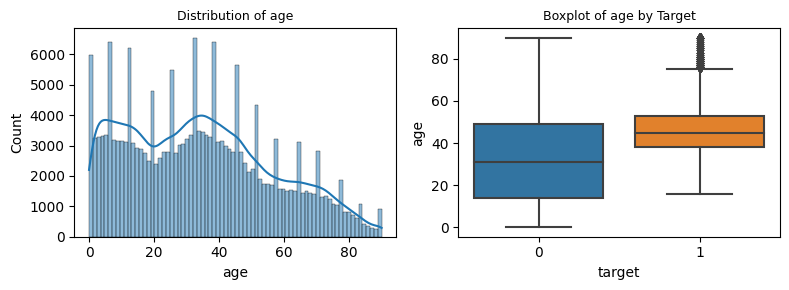

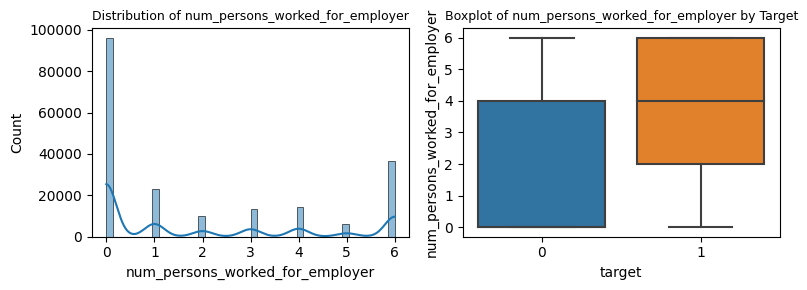

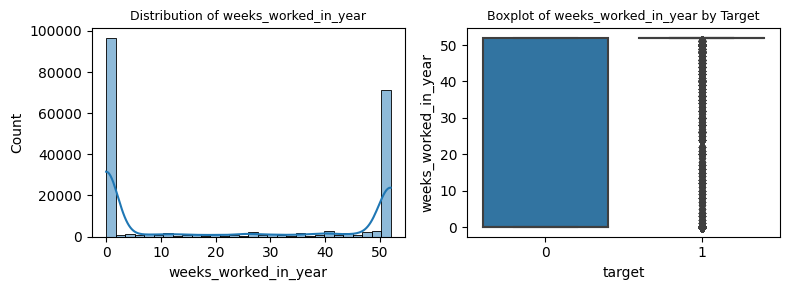

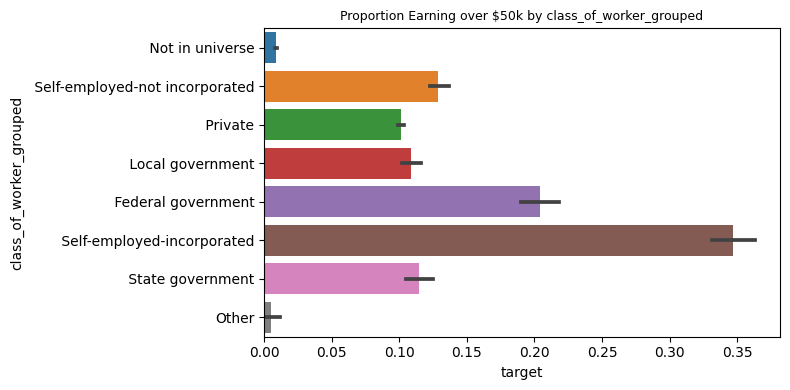

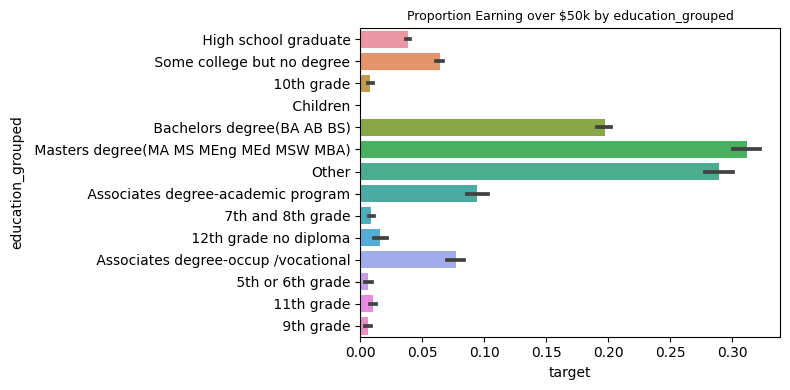

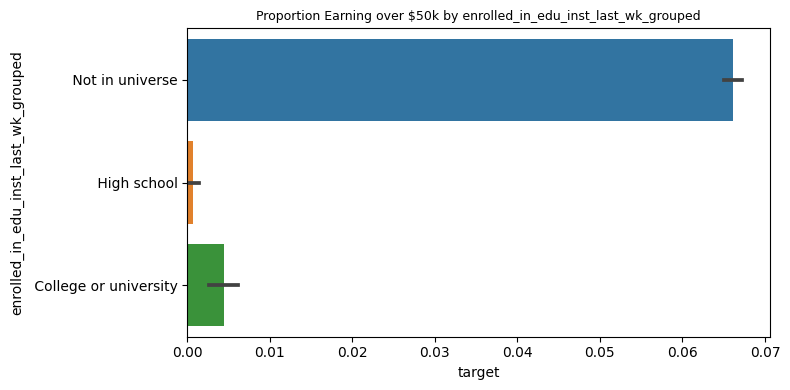

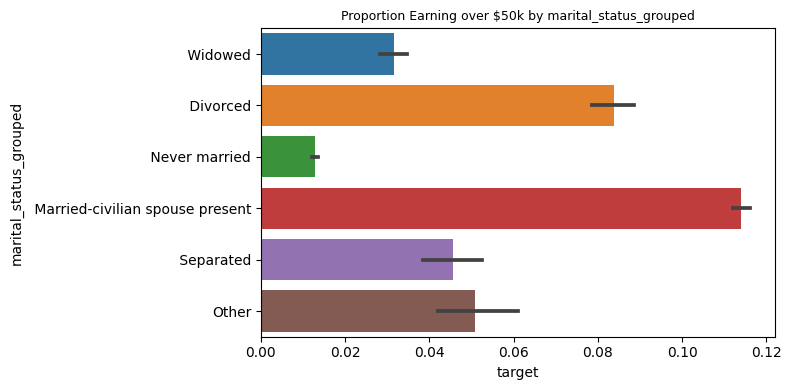

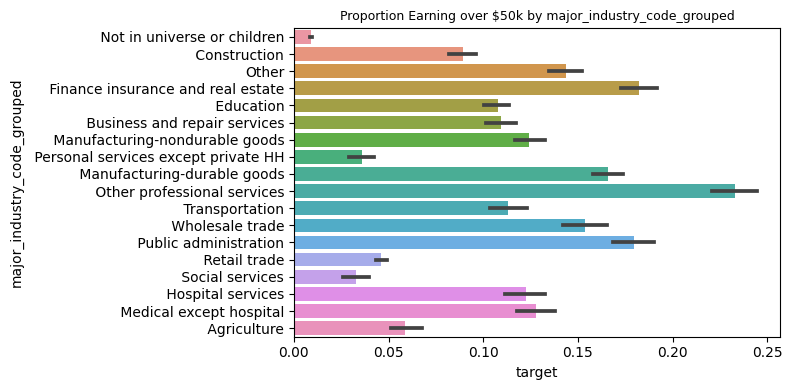

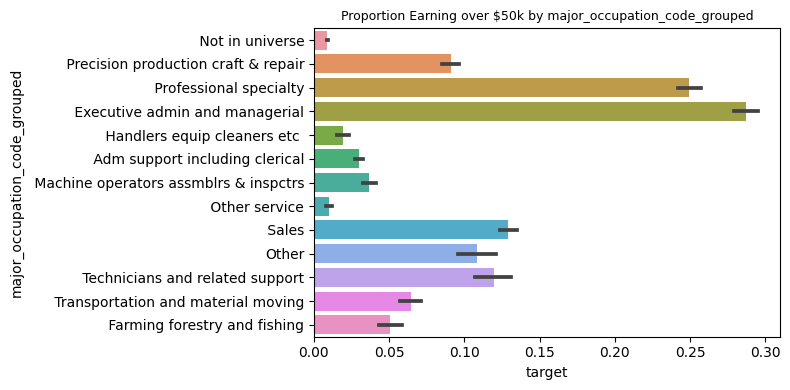

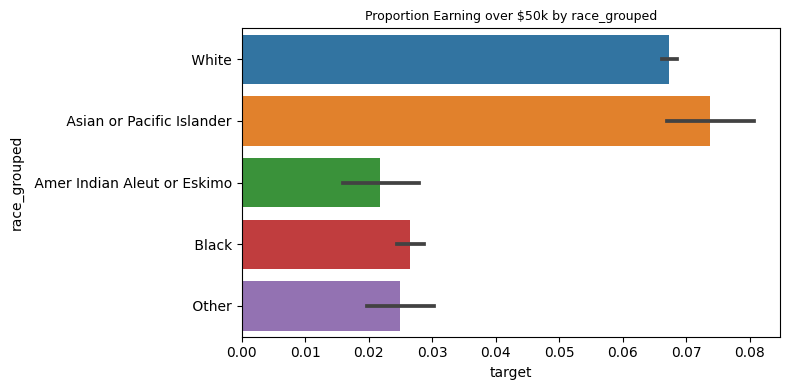

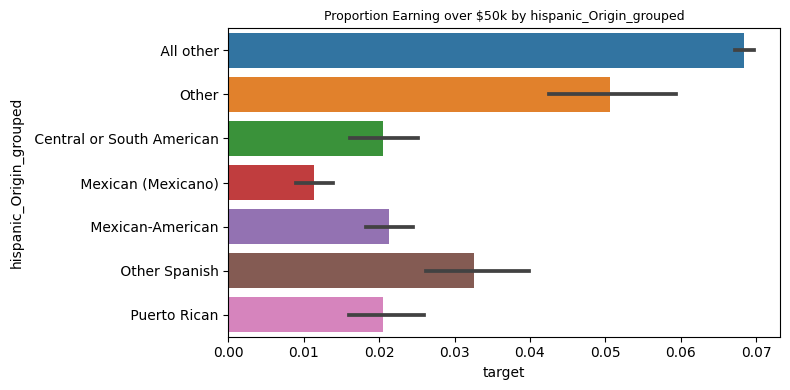

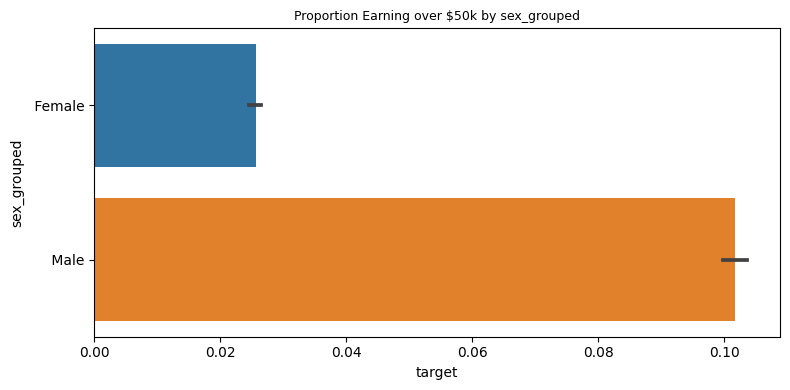

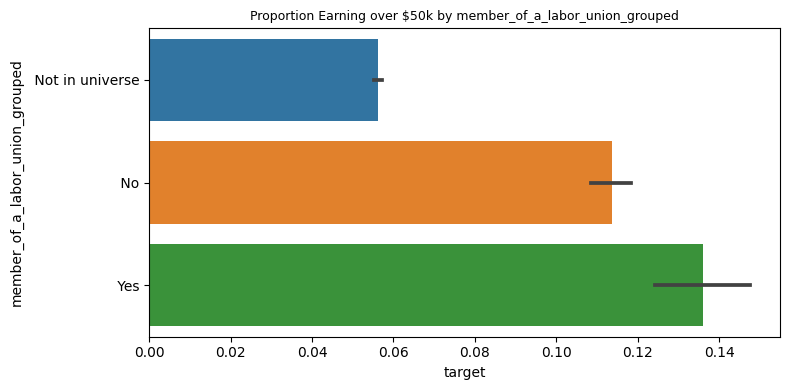

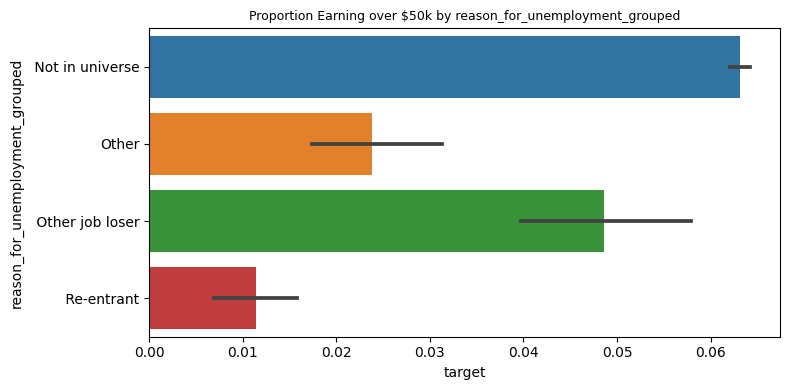

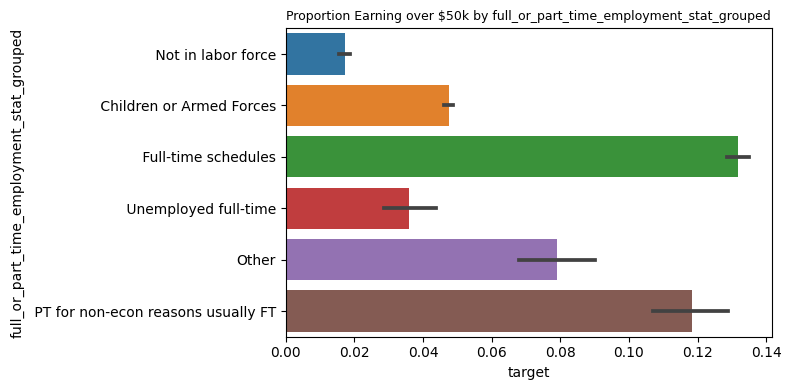

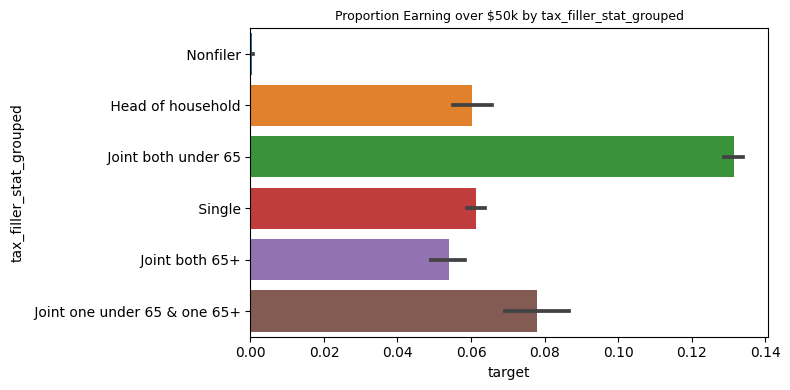

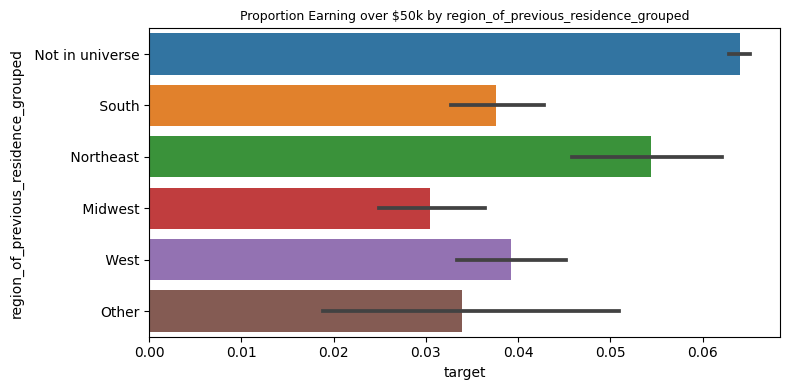

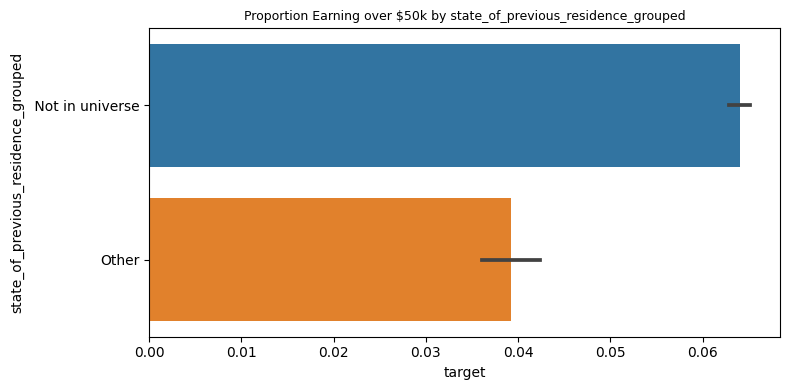

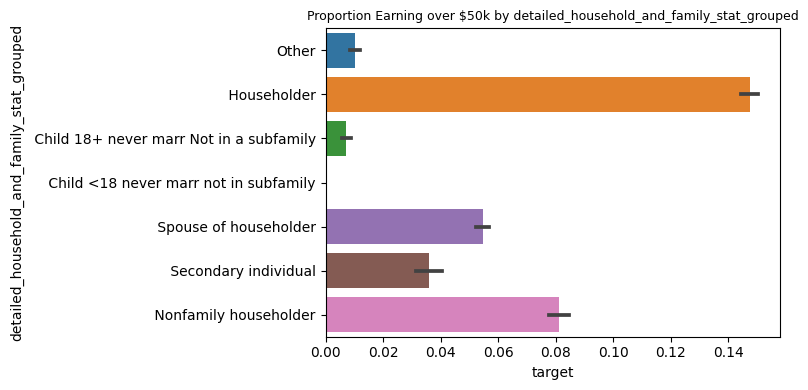

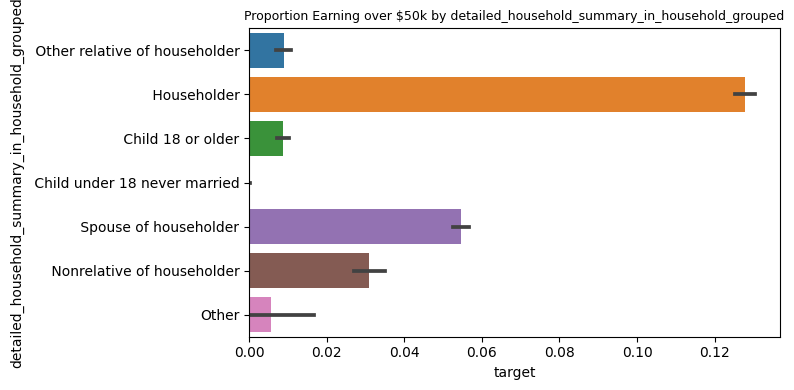

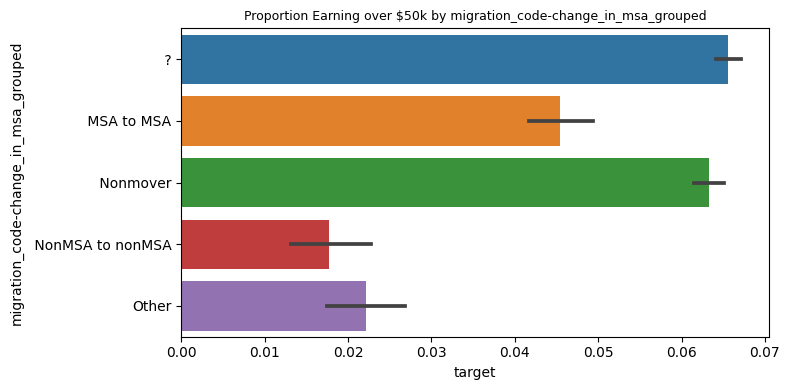

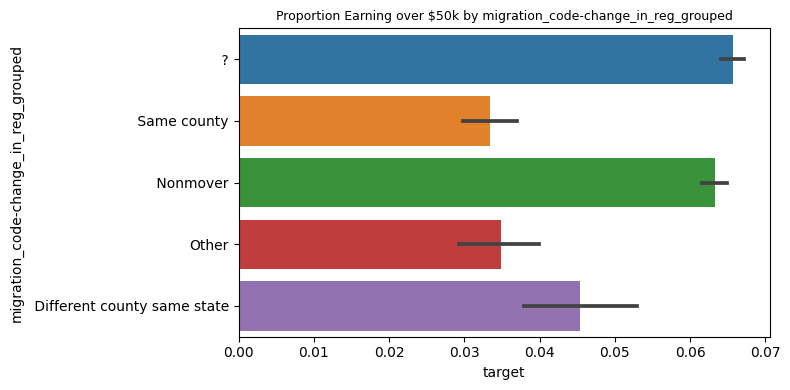

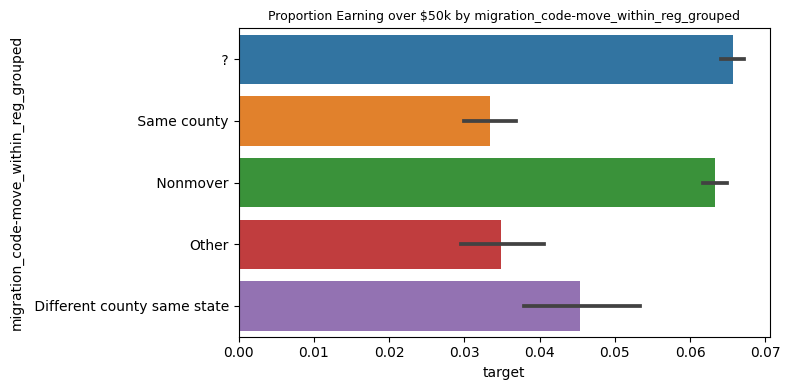

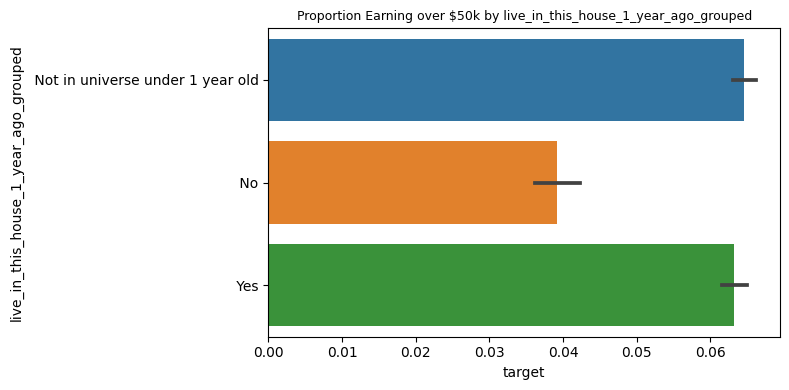

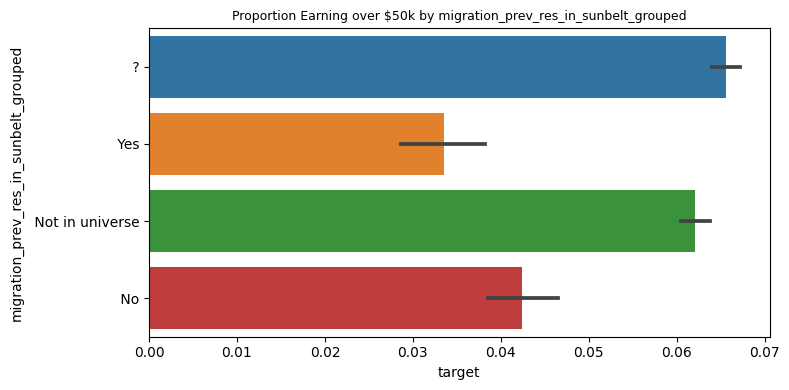

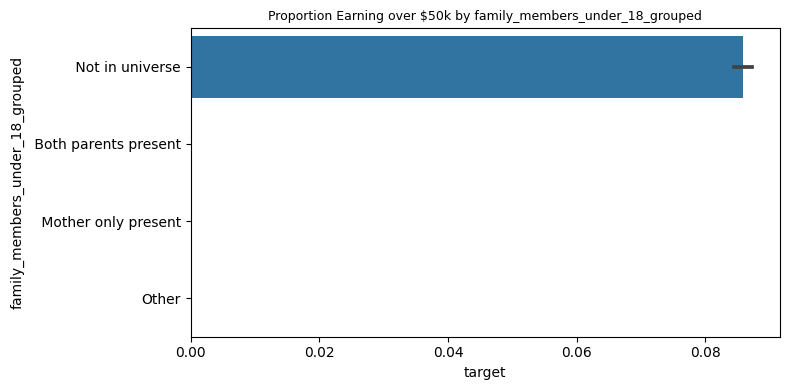

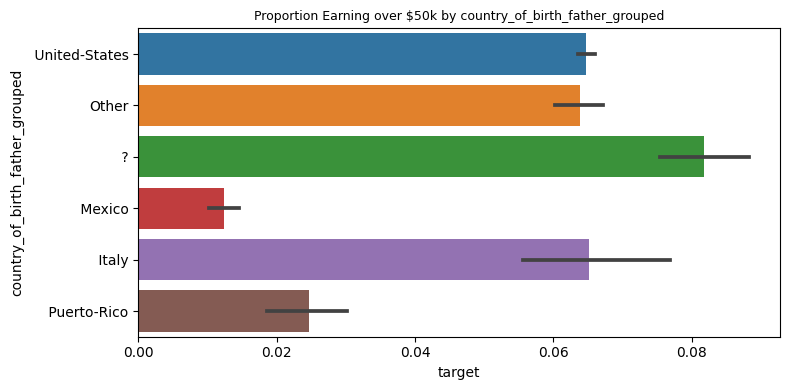

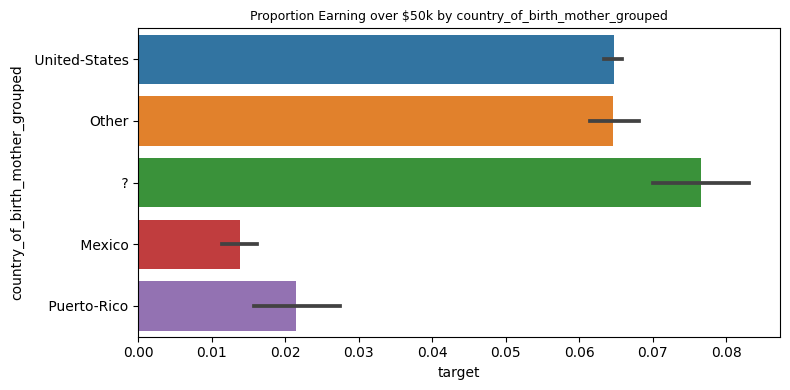

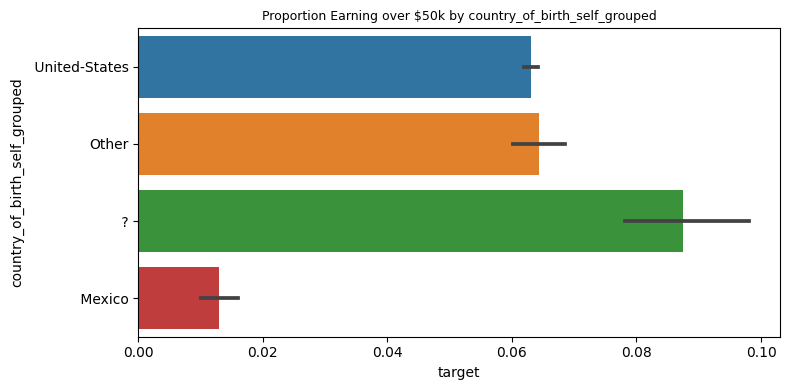

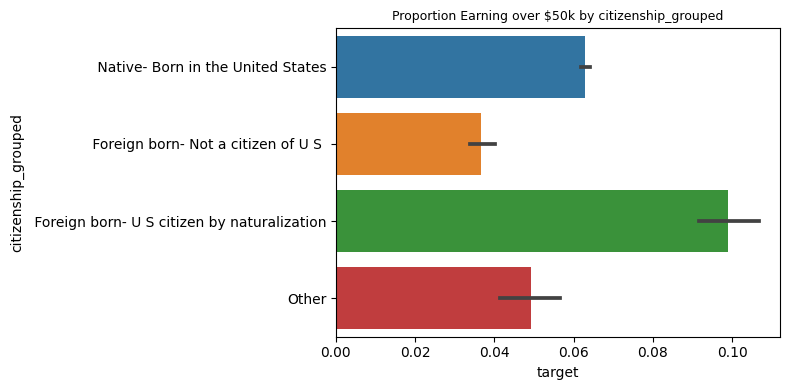

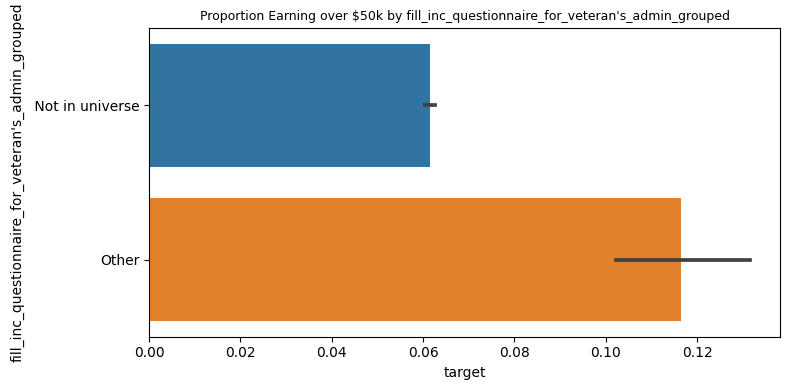

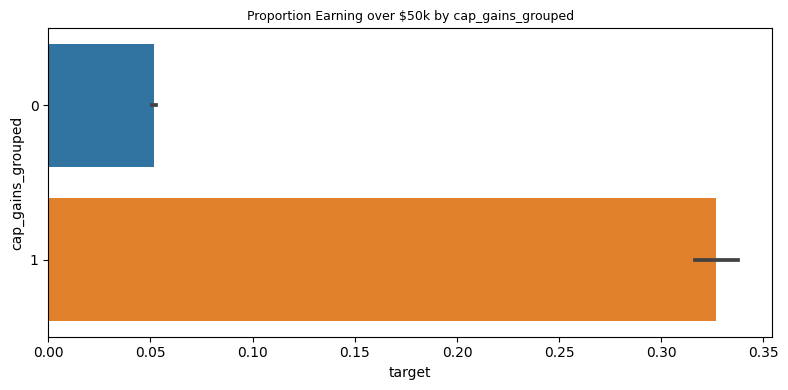

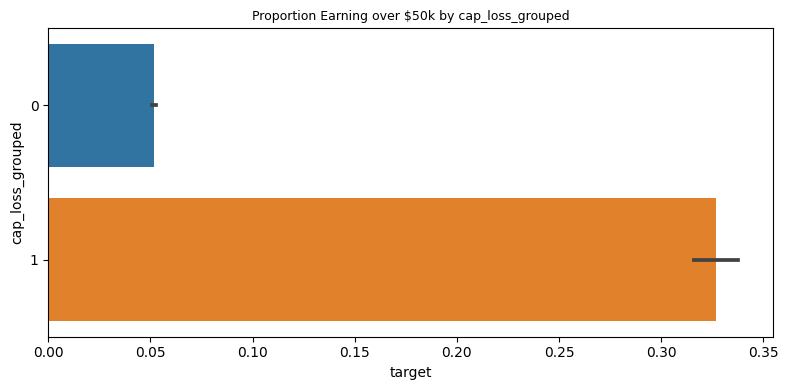

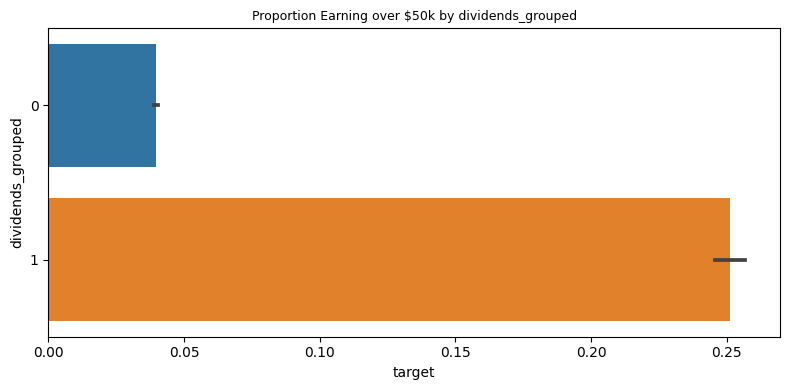

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# define columns
numeric = learn[['age', 'num_persons_worked_for_employer', 'weeks_worked_in_year']]
cat = learn[[col for col in learn.columns if col.endswith('_grouped')]]
# cat = learn[['education_grouped', 'cap_gains_grouped']]

# Visualizations for numerical columns
for column in numeric.columns:
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(learn[column], kde=True)
    plt.title(f'Distribution of {column}', fontsize=9)

    plt.subplot(1, 2, 2)
    sns.boxplot(data=learn, x='target', y=column)
    plt.title(f'Boxplot of {column} by Target', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Visualizations for categorical columns
for column in cat.columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=learn, y=column, x='target', orient='h')
    # plt.xticks(rotation=90) 
    plt.title(f'Proportion Earning over $50k by {column}', fontsize=9)
    
    plt.tight_layout()
    plt.show()
